# Disaster Response Message Classification

# Latar Belakang

Jika terjadi suatu bencana alam, banyak berita atau informasi yang diterima oleh organisasi penanganan bencana alam yang bersangkutan. Cara penyampaiannya pun beragam, baik secara langsung ataupun menggunakan media sosial. Mereka pun perlu menyaring lebih dari ribuan pesan yang masuk untuk ditangani sesuai permintaan bantuan.

Pada project ini, akan membuat sebuah **model klasifikasi** menggunakan data **teks**. Data tersebut adalah data ***disaster response message*** yang telah dikumpulkan oleh **figure-eight** atau yang sekarang dikenal dengan [**appen**](https://appen.com/).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
import contractions
import emoji

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

from collections import Counter
from wordcloud import WordCloud

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dimasprd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dimasprd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Dataset

In [2]:
messages = pd.read_csv('data/messages.csv')
categories = pd.read_csv('data/categories.csv')

In [3]:
messages

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct
...,...,...,...,...
26243,30261,The training demonstrated how to enhance micro...,NaN,news
26244,30262,A suitable candidate has been selected and OCH...,NaN,news
26245,30263,"Proshika, operating in Cox's Bazar municipalit...",NaN,news
26246,30264,"Some 2,000 women protesting against the conduc...",NaN,news


Pada dataset `messages` terdapat 26248 baris data dan terdapat 4 jenis kolom yaitu `id`, `message`, `original`, `genre`. Untuk pengolahan data lebih lanjut hanya akan menggunakan data pada kolom `message`.

In [4]:
categories

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...
...,...,...
26243,30261,related-0;request-0;offer-0;aid_related-0;medi...
26244,30262,related-0;request-0;offer-0;aid_related-0;medi...
26245,30263,related-1;request-0;offer-0;aid_related-0;medi...
26246,30264,related-1;request-0;offer-0;aid_related-1;medi...


Pada dataset `categories` juga terdapat 26248 baris data dan terdapat 2 kolom yaitu `id`, `categories`

# Eksplorasi Data Analisis

Pada kolom `categories` terdapat informasi label untuk setiap data pesan.

In [5]:
categories['categories']

0        related-1;request-0;offer-0;aid_related-0;medi...
1        related-1;request-0;offer-0;aid_related-1;medi...
2        related-1;request-0;offer-0;aid_related-0;medi...
3        related-1;request-1;offer-0;aid_related-1;medi...
4        related-1;request-0;offer-0;aid_related-0;medi...
                               ...                        
26243    related-0;request-0;offer-0;aid_related-0;medi...
26244    related-0;request-0;offer-0;aid_related-0;medi...
26245    related-1;request-0;offer-0;aid_related-0;medi...
26246    related-1;request-0;offer-0;aid_related-1;medi...
26247    related-1;request-0;offer-0;aid_related-0;medi...
Name: categories, Length: 26248, dtype: object

In [6]:
categories['categories'].iloc[0]

'related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0'

Label yang terdapat pada kolom `categories` masih dalam bentuk 1 data panjang, sehingga perlu untuk diolah menjadi bentuk data frame agar bisa digunakan untuk prediksi

In [7]:
# function untuk merapikan data categories
def categories_cleaner(data):
    df_category = pd.DataFrame([category.split("-") for category in data.categories.split(";")], columns=["category", "value"])
    return df_category

function untuk merapikan data pada kolom `categories` kemudian di aplikasikan ke seluruh nilai pada `DataFrame` categories

In [8]:
df = categories_cleaner(categories.loc[0])

for i in range(1, len(categories)-1):
    new_df = pd.merge(df, categories_cleaner(categories.loc[i]), on='category')
    df = new_df

Maka didapatkan kolom untuk setiap label kategori sebagai berikut

In [9]:
df_categories = df.set_index('category').transpose().reset_index(drop=True)

In [10]:
df_categories

category,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26242,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26245,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
categories['categories'].iloc[117]

'related-2;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0'

Pada categories data ke 117, terdapat nilai 2 pada kategori related. untuk mempermudah maka nilai 2 akan dirubah menjadi 1. sehingga angka 1 akan menunjukan bahwa suatu pesan masuk ke kategori tesebut, sedangkan angka 0 menunjukan bahwa suatu pesan tidak masuk ke kategori tersebut

In [12]:
df_categories = df_categories.replace(['2'], '1')

Dari 36 label kategori, kita akan melihat label kategori mana yang paling banyak

In [13]:
df_categories_int = df_categories.astype(int).sum()

In [14]:
df_categories_int

category
related                   20122
request                    4480
offer                       119
aid_related               10878
medical_help               2087
medical_products           1314
search_and_rescue           724
security                    471
military                    860
child_alone                   0
water                      1674
food                       2930
shelter                    2319
clothing                    406
money                       604
missing_people              299
refugees                    876
death                      1196
other_aid                  3448
infrastructure_related     1705
transport                  1203
buildings                  1335
electricity                 534
tools                       159
hospitals                   283
shops                       120
aid_centers                 309
other_infrastructure       1151
weather_related            7304
floods                     2158
storm                      2448

Disini hanya akan ditampilkan 5 label kategori terbanyak

In [15]:
label = df_categories_int.sort_values(ascending=False).head(5)

In [16]:
label

category
related            20122
aid_related        10878
weather_related     7304
direct_report       5081
request             4480
dtype: int64

Pada hasil diatas terlihat bahwa label kategori terbanyak terdiri dari `related`, `aid_related`, `request`, `direct_report`, dan `food`.

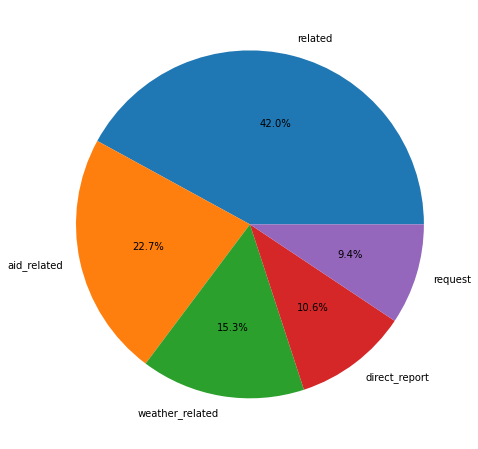

In [17]:
plt.figure(figsize=(8,8))
plt.pie(label.values, labels=label.index, autopct='%1.1f%%')
plt.show()

# Persiapan Data

Pertama-tama perlu dicek apakah urutan data pada dataset `message` sesuai dengan dataset `categories`. jika tidak tejadi error maka urutannya sudah sama

In [18]:
for i in range(len(messages['id'])):
    if messages['id'][i] == categories['id'][i]:
        pass
    else:
        break

Data kategori yang telah diolah kemudian perlu di gabung dengan data `message` agar lebih mudah untuk pengolahan data berikutnya

In [19]:
messages

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct
...,...,...,...,...
26243,30261,The training demonstrated how to enhance micro...,NaN,news
26244,30262,A suitable candidate has been selected and OCH...,NaN,news
26245,30263,"Proshika, operating in Cox's Bazar municipalit...",NaN,news
26246,30264,"Some 2,000 women protesting against the conduc...",NaN,news


In [20]:
messages = messages['message'][:]
data = pd.concat([messages, df_categories], axis=1)

In [21]:
data

,message,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,Weather update - a cold front from Cuba that c...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Is the Hurricane over or is it not over,1,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,Looking for someone but no name,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,UN reports Leogane 80-90 destroyed. Only Hospi...,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"says: west side of Haiti, rest of the country ...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26243,The training demonstrated how to enhance micro...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26244,A suitable candidate has been selected and OCH...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26245,"Proshika, operating in Cox's Bazar municipalit...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26246,"Some 2,000 women protesting against the conduc...",1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Kemudian dicek apakah pada data terdapat NaN value, jika ada maka perlu di drop/dibuang

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   message                 26248 non-null  object
 1   related                 26247 non-null  object
 2   request                 26247 non-null  object
 3   offer                   26247 non-null  object
 4   aid_related             26247 non-null  object
 5   medical_help            26247 non-null  object
 6   medical_products        26247 non-null  object
 7   search_and_rescue       26247 non-null  object
 8   security                26247 non-null  object
 9   military                26247 non-null  object
 10  child_alone             26247 non-null  object
 11  water                   26247 non-null  object
 12  food                    26247 non-null  object
 13  shelter                 26247 non-null  object
 14  clothing                26247 non-null  object
 15  mo

In [23]:
data.isna()

,message,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26243,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26244,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26245,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26246,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [24]:
data = data.dropna()

In [25]:
data

,message,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,Weather update - a cold front from Cuba that c...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Is the Hurricane over or is it not over,1,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,Looking for someone but no name,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,UN reports Leogane 80-90 destroyed. Only Hospi...,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"says: west side of Haiti, rest of the country ...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26242,"Hpakant, an area rich with coveted jade stones...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26243,The training demonstrated how to enhance micro...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26244,A suitable candidate has been selected and OCH...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26245,"Proshika, operating in Cox's Bazar municipalit...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26247 entries, 0 to 26246
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   message                 26247 non-null  object
 1   related                 26247 non-null  object
 2   request                 26247 non-null  object
 3   offer                   26247 non-null  object
 4   aid_related             26247 non-null  object
 5   medical_help            26247 non-null  object
 6   medical_products        26247 non-null  object
 7   search_and_rescue       26247 non-null  object
 8   security                26247 non-null  object
 9   military                26247 non-null  object
 10  child_alone             26247 non-null  object
 11  water                   26247 non-null  object
 12  food                    26247 non-null  object
 13  shelter                 26247 non-null  object
 14  clothing                26247 non-null  object
 15  mo

Sekarang jumlah semua data sudah sama, sehingga tidak ada lagi data yang NaN

Kemudian perlu dilakukan pengolahan pada data teks `message` agar bisa dirubah menjadi vector

In [27]:
def elongated_word(word):
    """
    Replaces an elongated word with its basic form, unless the word exists in the lexicon 
    """
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if (len(word)>2 and word[0] != '$'):#if not Stock Market symbol
        if wn.synsets(word):
            return word
        repl_word = repeat_regexp.sub(repl, word)
        if repl_word != word:      
            return elongated_word(repl_word)
        else:       
            return repl_word
    else:
        return word


def text_cleaner(text):
    '''
    clean input sentence  
    '''
    mention_pat= r'@[A-Za-z0-9_]+'
    mention_2_pat=r'@[A-Za-z0-9_]+:\s'
    retweet_pat=r'^RT +'
    http_pat = r'https?://[^ ]+'
    www_pat = r'www.[^ ]+'

    #Remove mention
    text = re.sub(mention_2_pat,'', text)
    text = re.sub(mention_pat,'', text)

    #Remove retweet
    text = re.sub(retweet_pat,'',text)

    #Remove url
    text = re.sub(http_pat, '', text)
    text = re.sub(www_pat, '', text)
    
    #Transform contracted and slang words into normal words
    #e.g yall're happy now -> you all are happy now
    text = contractions.fix(text)

    #Remove newline characters 
    text = text.replace('\n', ' ') 

    #Remove multiple spaces
    text = re.sub("\s\s+" , " ", text)

    #Remove hashtag
    text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    text = " ".join(word.strip() for word in re.split('#|_', text)) #remove just the hashtags (#) symbol from words in the middle of the sentence

    #Remove non utf8/ascii characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)

    #Remove Punctuation
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)

    #Remove elongated words 
    # e.g. "nooooo" -> "no"
    test_split = text.split()
    test_split = [elongated_word(x) if not x.isdigit() else x for x in test_split]
    text = " ".join(test_split)
    #Lowercase
    text = text.lower()

    #Remove any spaces at the start or end of the text
    text = text.strip()

    return text

In [28]:
stopwords_list = stopwords.words('english')

def remove_stopwords(text):
    text_split = text.split() #split text by space into a list of strings
    text_split = [x for x in text_split if x not in stopwords_list] #filter out stopwords
    text = ' '.join(text_split) #join list of strings into a string
    return text.strip()

def remove_emojis(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text)

Kemudian terapkan function diatas pada data `message` untuk membersihkan teks

In [29]:
data['CleanMessage'] = data['message'].apply(text_cleaner).apply(remove_stopwords).apply(remove_emojis)

In [30]:
data

,message,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,CleanMessage
0,Weather update - a cold front from Cuba that c...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,weather update cold front cuba could pass haiti
1,Is the Hurricane over or is it not over,1,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,hurricane
2,Looking for someone but no name,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,looking someone name
3,UN reports Leogane 80-90 destroyed. Only Hospi...,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,un reports leogane 8090 destroyed hospital st ...
4,"says: west side of Haiti, rest of the country ...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,says west side haiti rest country today tonight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26242,"Hpakant, an area rich with coveted jade stones...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,hpakant area rich coveted jade stones seen rec...
26243,The training demonstrated how to enhance micro...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,training demonstrated enhance micronutrient pr...
26244,A suitable candidate has been selected and OCH...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,suitable candidate selected ocha jakarta curre...
26245,"Proshika, operating in Cox's Bazar municipalit...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,proshika operating coxs bazar municipality 5 u...


Data yang sudah siap dilatih kemudian di split, sebanyak 80% untuk data latih dan 20% untuk data percobaan

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    data['CleanMessage'],
    data[['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
          'security', 'military','child_alone', 'water', 'food', 'shelter', 'clothing', 'money','missing_people',
          'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'electricity', 'tools', 'hospitals',
          'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake',
          'cold', 'other_weather', 'direct_report']],
    test_size=0.2, random_state=111
)

In [32]:
print(f"{len(X_train) = }.. {len(X_test) = }")

len(X_train) = 20997.. len(X_test) = 5250


Setelah dibagi, maka data teks perlu dikonversi menjadi vektor agar bisa dilatih menggunakan algoritma machine learning. teknik yang digunakan untuk merubah teks menjadi vektor pada kasus ini adalah TF-IDF BoW (*Term-Frequency - Inverse-Document-Frequency Bag of Words*) karena merupakan teknik yang dasar dan bisa meng-handle *frequency bias* pada data

In [33]:
vectorizer = TfidfVectorizer()
X_train_BoW = vectorizer.fit_transform(X_train.to_list())
X_test_BoW = vectorizer.transform(X_test.to_list())

In [34]:
X_train_BoW.shape

(20997, 33242)

Pada hasil diatas terlihat bahwa ukuran vektor yang terbentuk memiliki panjang 33242

# Model

## Pemilihan Model

Model klasifikasi yang akan digunakan adalah **Decision Tree** dan **Random Forest**

#### Decision Tree

Model menggunakan parameter default

In [37]:
dt = DecisionTreeClassifier()
# dt_classifier = MultiOutputClassifier(dt, n_jobs=-1)
# dt_classifier.fit(X_train_BoW, y_train)
dt.fit(X_train_BoW, y_train)

DecisionTreeClassifier()

In [39]:
dt_train_pred = dt.predict(X_train_BoW)
dt_test_pred = dt.predict(X_test_BoW)

dt_train_pred = dt.predict(X_train_BoW)
dt_test_pred = dt.predict(X_test_BoW)

In [40]:
dt_y_train_flatten = np.array(y_train).flatten()
dt_y_test_flatten = np.array(y_test).flatten()
dt_train_pred_flatten = dt_train_pred.flatten()
dt_test_pred_flatten = dt_test_pred.flatten()

#### Random Forest

Model menggunakan parameter default

In [42]:
rf = RandomForestClassifier(random_state=0)
# rf_classifier = MultiOutputClassifier(rf, n_jobs=-1)
# rf_classifier.fit(X_train_BoW, y_train)
rf.fit(X_train_BoW, y_train)

RandomForestClassifier(random_state=0)

In [43]:
# rf_train_pred = rf_classifier.predict(X_train_BoW)
# rf_test_pred = rf_classifier.predict(X_test_BoW)
rf_train_pred = rf.predict(X_train_BoW)
rf_test_pred = rf.predict(X_test_BoW)

In [44]:
rf_y_train_flatten = np.array(y_train).flatten()
rf_y_test_flatten = np.array(y_test).flatten()
rf_train_pred_flatten = rf_train_pred.flatten()
rf_test_pred_flatten = rf_test_pred.flatten()

## Evaluasi Model

In [45]:
print(
    "Decision Tree Performance on training set",
    classification_report(dt_y_train_flatten, dt_train_pred_flatten),
    sep='\n'
)

print(
    "Random Forest Performance on training set",
    classification_report(rf_y_train_flatten, rf_train_pred_flatten),
    sep='\n'
)

Decision Tree Performance on training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    669539
           1       1.00      1.00      1.00     65356

    accuracy                           1.00    734895
   macro avg       1.00      1.00      1.00    734895
weighted avg       1.00      1.00      1.00    734895

Random Forest Performance on training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    669539
           1       1.00      1.00      1.00     65356

    accuracy                           1.00    734895
   macro avg       1.00      1.00      1.00    734895
weighted avg       1.00      1.00      1.00    734895



In [46]:
print(
    "Decision Tree Performance on test set",
    classification_report(dt_y_test_flatten, dt_test_pred_flatten),
    sep='\n'
)

print(
    "Random Forest Performance on test set",
    classification_report(rf_y_test_flatten, rf_test_pred_flatten),
    sep='\n'
)

Decision Tree Performance on test set
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    167201
           1       0.64      0.53      0.58     16549

    accuracy                           0.93    183750
   macro avg       0.80      0.75      0.77    183750
weighted avg       0.93      0.93      0.93    183750

Random Forest Performance on test set
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    167201
           1       0.84      0.48      0.61     16549

    accuracy                           0.94    183750
   macro avg       0.89      0.73      0.79    183750
weighted avg       0.94      0.94      0.94    183750



## Penentuan Model Terbaik

In [47]:
max_depth_config = (5, 10)
min_samples_split_config = (5, 10, 50)

grid_search = GridSearchCV(
    dt,
    param_grid={
        "max_depth": max_depth_config,
        "min_samples_split": min_samples_split_config
    }
)
grid_search.fit(X_train_BoW, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': (5, 10),
                         'min_samples_split': (5, 10, 50)})

In [48]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_split': 5}

In [49]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_split=5)

In [50]:
print(
    "Decision Tree's performance on testing set (using Grid Search)",
    classification_report(dt_y_test_flatten, grid_search.predict(X_test_BoW).flatten()),
    sep="\n"
)

Decision Tree's performance on testing set (using Grid Search)
              precision    recall  f1-score   support

           0       0.94      0.99      0.97    167201
           1       0.78      0.42      0.54     16549

    accuracy                           0.94    183750
   macro avg       0.86      0.70      0.76    183750
weighted avg       0.93      0.94      0.93    183750



In [51]:
max_depth_config = (5, 10)
min_samples_split_config = (5, 10, 50)

grid_search = GridSearchCV(
    rf,
    param_grid={
        "max_depth": max_depth_config,
        "min_samples_split": min_samples_split_config
    }
)
grid_search.fit(X_train_BoW, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': (5, 10),
                         'min_samples_split': (5, 10, 50)})

In [52]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_split': 5}

In [53]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=5, min_samples_split=5, random_state=0)

In [54]:
print(
    "Random Forest's performance on testing set (using Grid Search)",
    classification_report(rf_y_test_flatten, grid_search.predict(X_test_BoW).flatten()),
    sep="\n"
)

Random Forest's performance on testing set (using Grid Search)
              precision    recall  f1-score   support

           0       0.93      0.99      0.96    167201
           1       0.77      0.25      0.37     16549

    accuracy                           0.93    183750
   macro avg       0.85      0.62      0.67    183750
weighted avg       0.92      0.93      0.91    183750



Dibawah ini merupakan akurasi prediksi untuk setiap label kategori (terdapat 35 label)

In [57]:
accuracy = []

columns = ['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
          'security', 'military','child_alone', 'water', 'food', 'shelter', 'clothing', 'money','missing_people',
          'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'electricity', 'tools', 'hospitals',
          'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake',
          'cold', 'other_weather', 'direct_report']

for i in range(0, len(columns)):
    print(
        f'{columns[i]} categories performance on test set',
        classification_report(np.array(y_test)[:,i], rf_test_pred[:,i]),
        sep="\n"
    )
    
    c_r = classification_report(np.array(y_test)[:,i], rf_test_pred[:,i], output_dict=True)
    accuracy.append(c_r['accuracy'])

related categories performance on test set
              precision    recall  f1-score   support

           0       0.67      0.48      0.56      1190
           1       0.86      0.93      0.89      4060

    accuracy                           0.83      5250
   macro avg       0.77      0.70      0.73      5250
weighted avg       0.82      0.83      0.82      5250

request categories performance on test set
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      4326
           1       0.83      0.52      0.64       924

    accuracy                           0.90      5250
   macro avg       0.87      0.75      0.79      5250
weighted avg       0.89      0.90      0.89      5250

offer categories performance on test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5227
           1       0.00      0.00      0.00        23

    accuracy                           1.00      5250
 

In [59]:
data_acc = {
    'label' : columns,
    'accuracy' : accuracy
}

df_acc = pd.DataFrame(data_acc)
df_acc

,label,accuracy
0,related,0.829143
1,request,0.897714
2,offer,0.995619
3,aid_related,0.761714
4,medical_help,0.920381
5,medical_products,0.951238
6,search_and_rescue,0.971619
7,security,0.982095
8,military,0.970095
9,child_alone,1.000000


# Kesimpulan

Model terbaik dalam mengklasifikasikan kategori pesan pada kasus ini adalah model Random Forest. Hasil `GridSearchCV` pada Random Forest tidak lebih baik dari model Random Forest awal (mungkin disebabkan karena rentang nilai yang belum pas), namun akurasi yang didapatkan sudah cukup tinggi yaitu 94% walaupun tanpa `GridSearchCV`.